<a href="https://colab.research.google.com/github/aorlandolopezudea/trafficsignrecognitionML/blob/main/02_Arquitectura_modelo_de_reconocimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **02 - Arquitectura modelo de reconocimiento**

En este notebook se construiran, entrenarán y evaluaran los modelos para el reconocimiento de la señal de tránsito presente en una imagen.

#*Cómo empezar?*

* Crea una copia de este notebook para que puedas modificarlo dando clic en **Archivo** en la barra de menú y clic en **Guardar una copia en drive**.

* En la barra de menú, de clic en **Entorno de ejecución** , luego en **Cambiar tipo de entorno de ejecución** y seleccione la opción **T4 GPU** como **Acelerador por hardware**.

# **1) Conectar con google drive**

In [ ]:
#@title Conexión a google drive
#@markdown Conectar a google drive para cargar los modelos.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2) Descargar recursos**

In [ ]:
#@title Utilitarios de archivos
#@markdown Funciones para descarga y descompresión de archivos.

import os

class FileUtils:

    @staticmethod
    def file_size(filename):
      size = os.path.getsize(filename)
      return size

    @staticmethod
    def download_file(url, output_filename):
        import subprocess
        comando = f"wget -O {output_filename} {url}"
        subprocess.run(comando, shell=True)
        print("File downloaded.")

    @staticmethod
    def decompress(filename, output_dir):
        import zipfile
        import os

        # Crea la carpeta de destino si no existe
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Descomprime el archivo zip
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        print("File decompressed")

In [ ]:
#@title Descarga de datasets
#@markdown Obtención de los datos para entrenamiento de los modelos.

#Dataset flo
dataset_url="https://github.com/aorlandolopezudea/trafficsignrecognitionML/raw/main/Recursos/Datasets/TrafficSignRecognitionDataset.zip"
filename="/content/dataset.zip"
FileUtils.download_file(dataset_url, filename)
output_dir = "/content/dataset"
print("File size (Kb): ", FileUtils.file_size(filename)/1024)
FileUtils.decompress(filename, output_dir)

#Dataset TrafficSignCroppedDataShanmukh05
dataset_url="https://github.com/aorlandolopezudea/trafficsignrecognitionML/raw/main/Recursos/Datasets/TrafficSignCroppedDataShanmukh05.zip"
filename="/content/TrafficSignCroppedDataShanmukh05.zip"
FileUtils.download_file(dataset_url, filename)
output_dir = "/content/dataset"
print("File size (Kb): ", FileUtils.file_size(filename)/1024)
FileUtils.decompress(filename, output_dir)

File downloaded.
File size (Kb):  65897.7666015625
File decompressed
File downloaded.
File size (Kb):  57927.94921875
File decompressed


# **3) Implementar clases y utilitarios**

In [ ]:
#@title Utilitarios de archivos CSV
#@markdown Lectura de archivos csv.

import pandas as pd

class CSVUtils:

    @staticmethod
    def load(file_path, delimiter):
            df = pd.read_csv(file_path, delimiter=delimiter)
            return df

import pandas as pd

class CSVUtils:

    @staticmethod
    def load(file_path, delimiter):
            df = pd.read_csv(file_path, delimiter=delimiter)
            return df

In [ ]:
#@title Utilitarios de imágenes
#@markdown Operaciones con imágenes.

import requests
from PIL import Image

class ImageUtils:

  @staticmethod
  def load_image_from_url(url):
    r = requests.get(url, stream=True)
    image = Image.open(r.raw)
    return image

  @staticmethod
  def save_image(image, file_path):
    image.save(file_path)

  @staticmethod
  def show_image(image):
    #plt.axis('off')
    #plt.imshow(image, cmap=plt.get_cmap('gray'))
    display(image)

  @staticmethod
  def resize_image(image, width, height):
    return image.resize((width, height))

  @staticmethod
  def scale_image(image, max_width, max_height):
      original_width, original_height = image.size
      ratio = min(max_width / original_width, max_height / original_height)
      new_width = min(int(original_width * ratio), max_width)
      new_height = min(int(original_height * ratio), max_height)
      scaled_image = image.resize((new_width, new_height), Image.LANCZOS)
      return scaled_image

  @staticmethod
  def center_image(image, final_width, final_height):
      # Create a blank image with the final dimensions
      combined_image = Image.new("RGB", (final_width, final_height))

      # Calculate the position to place the small image to center it
      start_x = (final_width - image.width) // 2
      start_y = (final_height - image.height) // 2

      # Paste the small image in the center of the blank image
      combined_image.paste(image, (start_x, start_y))

      return combined_image

  @staticmethod
  def crop_image(image, x1, y1, x2, y2):
      cropped_image = image.crop(x1, y1, x2, y2)
      return cropped_image

  @staticmethod
  def crop_image_center(image, x_center, y_center, width, height):
      left = x_center - width // 2
      top = y_center - height // 2
      right = x_center + width // 2
      bottom = y_center + height // 2
      cropped_image = image.crop((left, top, right, bottom))
      return cropped_image

In [ ]:
#@title Utilitarios de modelos NN
#@markdown Operaciones con modelos NN.

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
import tensorflow.keras.models as kerasmodels

class NNModelUtils:

    @staticmethod
    def create_cnn_model(img_width, img_height, num_classes, num_convolutions, num_filters, units_dense_layer):
        name=f'C{num_convolutions}_F{num_filters}_D{units_dense_layer}'
        model = Sequential(name=name)
        model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
        f=num_filters
        for i in range(1, num_convolutions+1):
          model.add(Conv2D(f, 3, padding='same', activation='relu'))
          model.add(MaxPooling2D(pool_size=2))
          f=f*2
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(units_dense_layer, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation = 'softmax'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    @staticmethod
    def create_cnn_models(img_width, img_height, num_classes, num_convolutions=[2, 4], num_filters=[4, 16], units_dense_layer=[64, 128]):
      models=[]
      for convolutions in num_convolutions:
        for filters in num_filters:
          for dense_units in units_dense_layer:
            print(f'convolutions: {convolutions}, filters: {filters}, dense_units: {dense_units}')
            model=NNModelUtils.create_model(img_width, img_height,len(num_classes), convolutions, filters, dense_units)
            models.append(model)
      return models

    @staticmethod
    def get_model_name(models, index):
      return models[index].name

    @staticmethod
    def plot_model(model):
      return keras.utils.plot_model(
          model,
          show_shapes=True,
          show_dtype=True,
          show_layer_activations=True
      )

    @staticmethod
    def training_model(model, epochs, train_generator, test_generator, batch_size):
      print(model.summary())
      history = model.fit(train_generator,
              steps_per_epoch=train_generator.samples // batch_size,
              epochs=epochs,
              validation_data=test_generator,
              validation_steps=test_generator.samples // batch_size)
      results=NNModelUtils.create_last_history_table([model], [history])
      print(results)
      return history

    @staticmethod
    def training_models(models, epochs, train_generator, test_generator, batch_size):
      histories=[]
      for model in models:
        history=NNModelUtils.training_model(model, epochs, train_generator, test_generator, batch_size)
        histories.append(history)
      return histories

    @staticmethod
    def predict(model, img):
      img_array = np.array(img)
      input_image_batch = np.expand_dims(img_array, axis=0)
      return model.predict(input_image_batch)

    @staticmethod
    def predict_from_image(model, image, img_width, img_height):
      #ImageUtils.show_image(image)
      scaled_image = ImageUtils.scale_image(image, img_width, img_height)
      #ImageUtils.show_image(scaled_image)
      centered_image = ImageUtils.center_image(scaled_image, img_width, img_height)
      ImageUtils.show_image(centered_image)

      return NNModelUtils.predict(model, centered_image)

    @staticmethod
    def predict_from_url(model, url, img_width, img_height):
      image= ImageUtils.load_image_from_url(url)
      return NNModelUtils.predict_from_image(model, image, img_width, img_height)


    @staticmethod
    def history_table(histories):
        # Convertir cada historial en un DataFrame de Pandas y agregar una columna 'epoch'
        dfs = []
        for i, history in enumerate(histories, start=1):
            df = pd.DataFrame(history.history)
            df['epoch'] = df.index + 1
            df.columns = [f'{col}_model{i}' for col in df.columns]
            dfs.append(df)

        # Fusionar los DataFrames en uno solo utilizando la columna 'epoch'
        merged_df = pd.concat(dfs, axis=1)

        return merged_df

    @staticmethod
    def create_last_history_table(models, all_histories):
        # Crear una lista para almacenar los datos
        data = []

        # Recorrer cada historial
        for i, history in enumerate(all_histories):
            name=NNModelUtils.get_model_name(models, i)
            # Obtener los últimos valores de accuracy, val_accuracy, loss y val_loss
            accuracy = history.history['accuracy'][-1]
            val_accuracy = history.history['val_accuracy'][-1]
            loss = history.history['loss'][-1]
            val_loss = history.history['val_loss'][-1]

            # Agregar una fila para este modelo a la lista de datos
            data.append({"Model": f"Model {name}", "Val Accuracy": val_accuracy})

        # Crear un DataFrame a partir de la lista de datos
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def save_model(model, filename):
      model.save(filename)
      print ("Model saved in ", filename)

    @staticmethod
    def load_model(filename):
      model = kerasmodels.load_model(filename)
      print ("Model loaded ", filename)
      return model

In [ ]:
#@title Clase DatasetLoader
#@markdown Interface del cargador de datos para entrenar y validar los modelos.

import pandas as pd

class DatasetLoader:
    def __init__(self):
      return

    def initialize_classes(self):
      pass

    def initialize_labels(self):
      pass

    def get_path_train(self):
      pass

    def get_path_validation(self):
      pass

In [ ]:
#@title Clase DatasetLoaderFlo
#@markdown Cargador de datos del repositorio Flo para entrenar y validar los modelos.


import pandas as pd

class DatasetLoaderFlo(DatasetLoader):
    def __init__(self):
      self.PATH_BASE = '/content/dataset/TrafficSignRecognitionDataset'
      self.PATH_TRAIN = self.PATH_BASE + '/dataset/train'
      self.PATH_VALIDATION = self.PATH_BASE + '/dataset/validation'

    def get_path_train(self):
      return self.PATH_TRAIN

    def get_path_validation(self):
      return self.PATH_VALIDATION

    def initialize_classes(self):
      classes = []
      for d in os.listdir(self.PATH_TRAIN):
          if os.path.isdir(os.path.join(self.PATH_TRAIN, d)) and not d.startswith('.'):
              classes.append(d)
      return classes

    def initialize_labels(self):
      labels= CSVUtils.load(self.PATH_BASE +  '/labels.csv', ',')
      return labels

In [ ]:
#@title DatasetLoaderShanmukh05
#@markdown Cargador de datos del repositorio Shanmukh05 para entrenar y validar los modelos.

class DatasetLoaderShanmukh05(DatasetLoader):
    def __init__(self):
      self.PATH_BASE = '/content/dataset/TrafficSignCroppedDataShanmukh05'
      self.PATH_TRAIN = self.PATH_BASE + '/dataset/train'
      self.PATH_VALIDATION = self.PATH_BASE + '/dataset/validation'

    def get_path_train(self):
      return self.PATH_TRAIN

    def get_path_validation(self):
      return self.PATH_VALIDATION

    def initialize_classes(self):
      classes = []
      for d in os.listdir(self.PATH_TRAIN):
          if os.path.isdir(os.path.join(self.PATH_TRAIN, d)) and not d.startswith('.'):
              classes.append(d)
      return classes

    def initialize_labels(self):
      labels= CSVUtils.load(self.PATH_BASE +  '/labels.csv', ',')
      return labels

In [ ]:
#@title Clase DatasetProvider
#@markdown Proveedor de datos para entrenar y validar los modelos.

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DatasetProvider:
    def __init__(self, img_width, img_height, batch_size, datasetLoader:DatasetLoader):
      self.img_width = img_width
      self.img_height = img_height
      self.batch_size = batch_size
      self.datasetLoader=datasetLoader
      self._classes = self.datasetLoader.initialize_classes()
      self._labels = self.datasetLoader.initialize_labels()
      self._train_generator = self.initialize_train_generator()
      self._test_generator = self.initialize_test_generator()

    @property
    def classes(self):
      return self._classes

    @property
    def labels(self):
      return self._labels

    @property
    def train_generator(self):
      return self._train_generator

    @property
    def test_generator(self):
      return self._test_generator

    def initialize_train_generator(self):
      train_datagen = ImageDataGenerator(
          rescale=1./255,
          zoom_range=[0.5, 1.5],
          #height_shift_range=0.15,
          #width_shift_range=0.15,
          #fill_mode='nearest',
          #rotation_range=5,
          #shear_range=60,
          #brightness_range=[0,2]
          horizontal_flip=False
      )
      train_generator = train_datagen.flow_from_directory(
          self.datasetLoader.get_path_train(),
          target_size=(self.img_width, self.img_height),
          batch_size=self.batch_size,
          class_mode='categorical'
      )
      return train_generator

    def initialize_test_generator(self):
      test_datagen = ImageDataGenerator(rescale=1./255)
      test_generator = test_datagen.flow_from_directory(
          self.datasetLoader.get_path_validation(),
          target_size=(self.img_width, self.img_height),
          batch_size=self.batch_size,
          class_mode='categorical'
      )
      return test_generator

    def random_test_image(self):
      images, labels = self.train_generator.next()
      image=Image.fromarray((images[0] * 255).astype(np.uint8))
      label=labels[0]
      return image, label

In [ ]:
#@title Clase Recognizer
#@markdown Clase para clasificar el objeto en una imagen usando el modelo de red convolucional.

class Recognizer:
    def __init__(self, model, dataset_provider, img_width, img_height):
      self.model=model
      self.dataset_provider=dataset_provider
      self.img_width=img_width
      self.img_height=img_height

    def recognize(self, image):
      prediction = NNModelUtils.predict_from_image(self.model, image, self.img_width, self.img_height)
      index=np.argmax(prediction,axis=1)[0]
      name = self.dataset_provider.labels['Name'][index]
      probability = prediction[0][index]
      return RecognizerResult(prediction, index, name, probability)

    def recognize_from_url(self, url):
      image= ImageUtils.load_image_from_url(url)
      return self.recognize(image)

class RecognizerResult:
    def __init__(self, prediction, index, name, probability):
      self.prediction=prediction
      self.index=index
      self.name=name
      self.probability=probability

    def summary(self):
      print(f'Prediction: {self.prediction}')
      print(f'Index: {self.index}')
      print(f"Name: {self.name}")
      print(f"Probability: {self.probability}")

# **4) Ejecución de la aplicación**

In [ ]:
#@title Inicialización
#@markdown Inicialización de las variables de ejecución.

img_width, img_height = 32, 32
batch_size = 32

In [ ]:
#@title Inicializar el DatasetProvider
#@markdown Inicializacion del DatasetProvider correspondiente al dataset del repositorio seleccionado.
repository="Shanmukh05"  # @param ["Flo", "Shanmukh05"] {allow-input: false}

datasetLoader=None

if repository=="Flo":
  print("Flo repository")
  datasetLoader=DatasetLoaderFlo()
else:
  print("Shanmukh05 repository")
  datasetLoader=DatasetLoaderShanmukh05()
dataset_provider = DatasetProvider(img_width, img_height, batch_size, datasetLoader)

print("Classes")
classes = dataset_provider.classes
print ("There are ", len(classes), "classes:\n", classes)

print()
print("Labels")
original_labels= dataset_provider.labels
print(original_labels)
name = original_labels['Name'][42]
print(f"Valor en la fila {42} y columna 'column_name': {name}")

Shanmukh05 repository
Found 26640 images belonging to 43 classes.
Found 14629 images belonging to 43 classes.
Classes
There are  43 classes:
 ['40', '09', '42', '27', '38', '12', '22', '01', '30', '34', '20', '03', '31', '17', '05', '00', '28', '04', '08', '07', '32', '10', '23', '16', '25', '37', '35', '33', '06', '41', '24', '15', '11', '39', '21', '19', '29', '26', '36', '13', '02', '14', '18']

Labels
    ClassId                                               Name
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8             

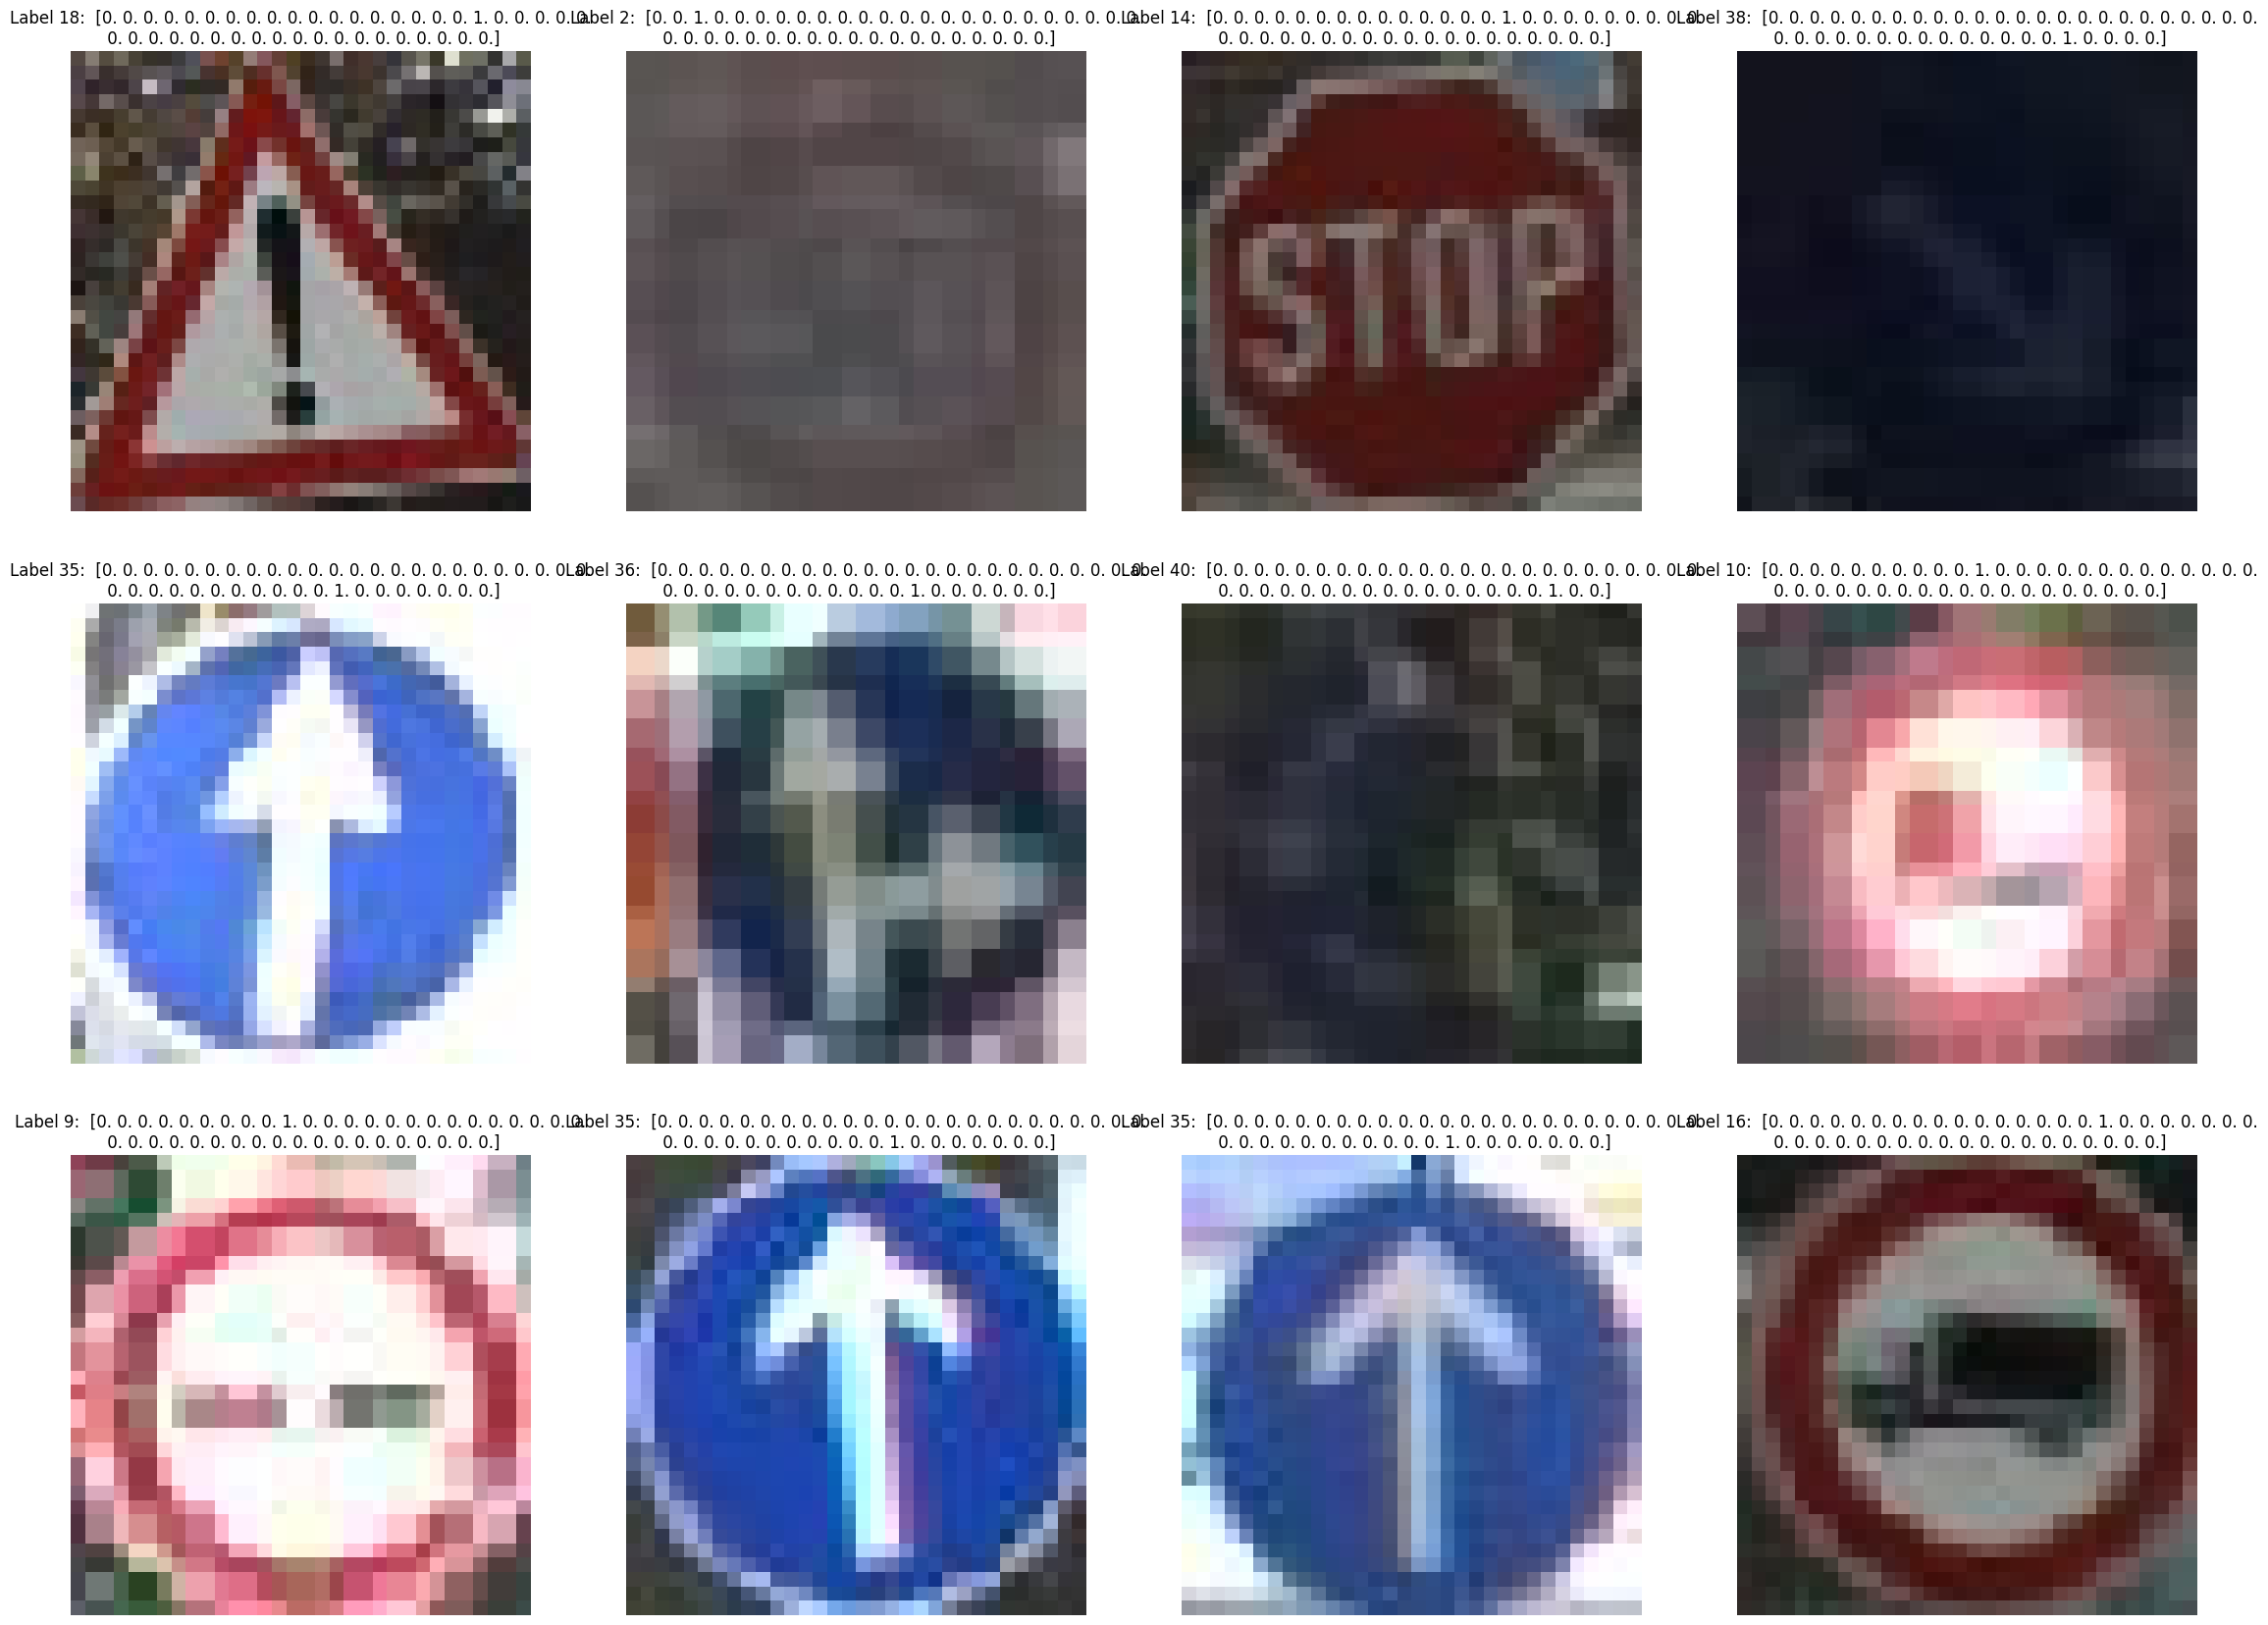

In [ ]:
#@title Mostrar imágenes
#@markdown Mostrar algunas imágenes del DatasetProvider.

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the train_generator
images, labels = dataset_provider.train_generator.next()

# Plot the images
plt.figure(figsize=(28, 28))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label {np.argmax(labels[i])}:  {labels[i]}')
    plt.axis('off')
plt.show()

Model: "C2_F28_D128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 28)        784       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 28)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 56)        14168     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 56)          0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 56)          

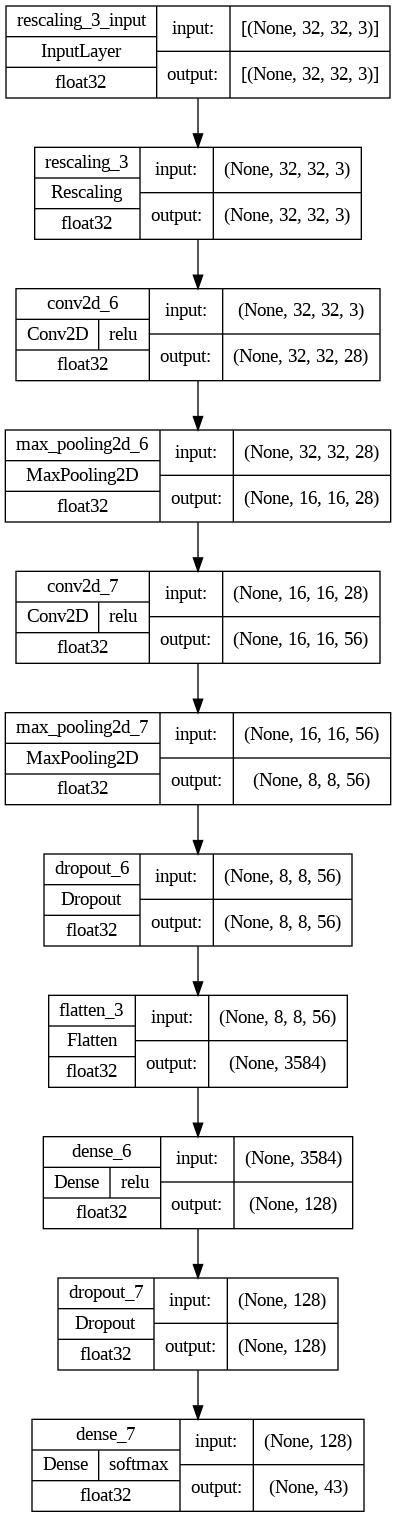

In [ ]:
#@title Crear modelo CNN
#@markdown  Establece el número de convoluciones, el número de filtros y el número de unidades de la capa densa para crear el modelo convolucional.

num_classes=len( dataset_provider.classes)
num_convolutions="2"  # @param ["1", "2", "3", "4"] {allow-input: true}
num_filters="28"  # @param ["4", "16", "28", "32", "64"] {allow-input: true}
units_dense_layer="128"  # @param ["32", "64", "128", "256"] {allow-input: true}
model= NNModelUtils.create_cnn_model(img_width, img_height,num_classes, int(num_convolutions), int(num_filters), int(units_dense_layer))
model.summary()
NNModelUtils.plot_model(model)

In [ ]:
#@title Entrenar el modelo
#@markdown Selecciona o edita el número de épocas para entrenar el modelo creado.

epochs = '10' # @param ["1", "5", "10", "25", "50", "100"] {allow-input: true}
history=NNModelUtils.training_model(model, int(epochs), dataset_provider.train_generator, dataset_provider.test_generator, batch_size)

Model: "C2_F28_D128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 28)        784       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 28)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 56)        14168     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 56)          0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 56)          

In [ ]:
#@title Guardar el modelo
#@markdown Guarda el modelo en su google drive.

model_path='/content/drive/My Drive/model_cnn_' + model.name + '.keras'
NNModelUtils.save_model(model, model_path )

Model saved in  /content/drive/My Drive/model_cnn_C2_F28_D128.keras


In [ ]:
#@title Crear Recognizer
#@markdown Inicializa la clase de reconocimento usando el modelo CNN almacenado en su google drive.

#@markdown Establezca la ruta donde se encuentra el modelo entrenado.
model_path='/content/drive/My Drive/model_cnn_C2_F28_D128.keras'  # @param {type:"string"}

model = NNModelUtils.load_model(model_path)
model.summary()
recognizer=Recognizer(model, dataset_provider, img_width, img_height)

Model loaded  /content/drive/My Drive/model_cnn_C2_F28_D128.keras
Model: "C2_F28_D128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 28)        784       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 28)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 56)        14168     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 56)          0         
 g2D)                                                            
                                                       

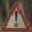

Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



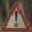

1/1 [==============================] - 0s 17ms/step
Prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Index: 18
Name: General caution
Probability: 1.0


In [ ]:
# @title Probar el reconocimiento desde el conjunto de datos
#@markdown Prueba del reconocimiento desde una imagen aleatoria del conjunto de datos.

image, label = dataset_provider.random_test_image()
ImageUtils.show_image(image)
print(f'Label: {label}')
print(f'')
prediction=recognizer.recognize(image)
prediction.summary()

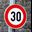

1/1 [==============================] - 0s 41ms/step
Prediction: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Index: 4
Name: Speed limit (70km/h)
Probability: 1.0


In [ ]:
# @title Probar el reconocimiento con imagenes de internet
#@markdown Seleccione o edite la url de la imagen para probar el reconocimiento.

image_url = 'https://cdn-trans.info/uploads/2023/10/2fb142318c88edb80ad182f4408.jpg' # @param ["https://cdn-trans.info/uploads/2023/10/2fb142318c88edb80ad182f4408.jpg", "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQQJty9wPcVNHPXxJtbnayKADq6dvzA61w7MGncCfxPLA&s", "https://media.istockphoto.com/id/472360055/vector/german-road-sign-speed-limit-100-kmh.jpg?s=612x612&w=0&k=20&c=18wEbgsaRsRkFD5OoJwIxgvMvdjDzhoygLKffCbPHJo=", "https://www.shutterstock.com/shutterstock/photos/2085281161/display_1500/stock-photo-license-plates-compulsory-roundabout-of-wheeled-vehicles-2085281161.jpg", "https://www.lorenzoandlorenzo.com/wordpress_en2/wp-content/uploads/22e3132c89a1aee6cdbc650b429abb79.jpeg"] {allow-input: true}

prediction=recognizer.recognize_from_url(image_url)
prediction.summary()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(dataset_provider.test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas del generador
y_true = dataset_provider.test_generator.classes

# Paso 3: Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

458/458 [==============================] - 6s 13ms/step


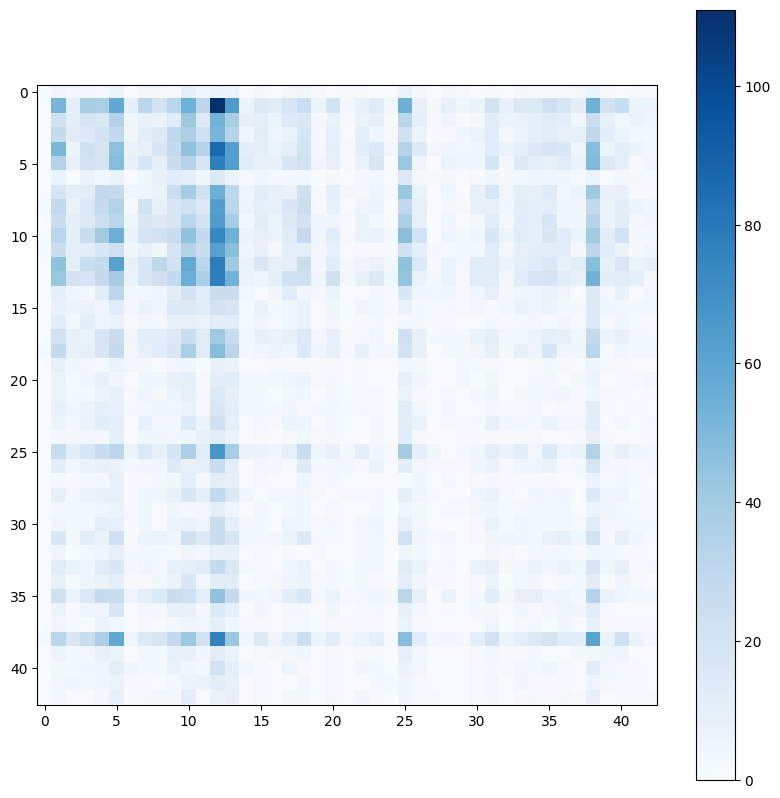

In [ ]:

# Paso 4: Visualizar la matriz de confusión solo con los colores
plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura

# Crear una imagen de la matriz de confusión
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Ocultar etiquetas y valores de los ejes
#plt.xticks([])
#plt.yticks([])

# Ocultar los valores en las celdas de la matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, "", ha="center", va="center", color="black")

plt.show()